In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import os,sys
from datetime import datetime
from scipy.signal import detrend

import warnings
warnings.filterwarnings("ignore")

### Read in information about the SAM index and EOF (based on u) 

In [4]:
ds_sam = xr.open_dataset("ERA5_1980_2023_SAMindex_u_S20.nc")


In [5]:
ds_sam

<xarray.Dataset>
Dimensions:   (time: 16071, lat: 249)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31
  * lat       (lat) float64 -89.86 -89.58 -89.3 -89.02 ... -20.67 -20.39 -20.11
Data variables:
    u_sam     (time, lat) float64 ...
    SAMindex  (time) float64 ...
    SAMeof    (lat) float64 ...

### Read in information about m (eddy forcing of the SAM) and [u bar]_s

In [6]:
indir='/work/bk1377/b382037/WP7/Eddyfeedbackstrength/new/' 

ds = xr.open_mfdataset(''+indir+'ERA5_SAMeddyforcingstrength_*_S20_new.nc', concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override')


In [7]:
ds

<xarray.Dataset>
Dimensions:      (time: 16071)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31
Data variables:
    eddyforcing  (time) float64 dask.array<chunksize=(366,), meta=np.ndarray>
    u1D          (time) float64 dask.array<chunksize=(366,), meta=np.ndarray>

### Lagged linear regression onto the SAM index...
such that for a lag l,


  m(t+l)~ beta_m(l)PC(t)


u1D(t+l)~ beta_u(l)PC(t)

In [8]:
eddym = ds['eddyforcing'].to_numpy()
u1D   = ds['u1D'].to_numpy()

In [9]:
nt = eddym.shape[0]

In [10]:
samindex=ds_sam['SAMindex'].isel(time=slice(30,nt-31))

In [11]:
print(eddym)

[-3.86636930e-05 -1.10633624e-04 -4.38255364e-05 ...  3.85124599e-05
  8.68628762e-05  7.51908209e-05]


In [12]:
print(u1D)

[ -4.05546843  -8.59589499 -17.16621006 ...  15.88684627  18.15294815
  19.97614739]


In [13]:
print(nt, nt-31)

16071 16040


In [14]:
print(ds.coords['time'].isel(time=slice(30,nt-31)).shape)

(16010,)


In [15]:
lags_size = np.arange(-30,31,1)
print(lags_size.shape)

(61,)


In [16]:
print(eddym[0:61].shape)

(61,)


In [17]:
coords_time= {'time':ds.coords['time'].isel(time=slice(30,nt-31)),'lags':np.arange(-30,31,1)}

mlag_window    = xr.DataArray(np.full((61,nt-61),fill_value=np.nan), dims=["lags","time"], coords= coords_time)
ulag_window    = xr.DataArray(np.full((61,nt-61),fill_value=np.nan), dims=["lags","time"], coords= coords_time)

for i in range(0+30, nt-31):  # Adjust indices to account for slicing
       # Extract the 60-day window around the current day   
        window_data_m = eddym[i-30:i+31]  
        window_data_u = u1D[i-30:i+31]  
        mlag_window.isel(time=i-30).values[:]  = window_data_m
        ulag_window.isel(time=i-30).values[:]  = window_data_u

### For Annual mean

In [18]:
from scipy.stats import linregress

ANNslope_m = np.zeros((61))
ANNslope_u = np.zeros((61))

for lag in range (0,61):
    ANNslope_m[lag], _, _, _, _ = linregress(samindex.to_numpy(), mlag_window[lag,:].to_numpy())  #slope, intercept, r_value, p_value, std_err = linregress(x, y)
    ANNslope_u[lag], _, _, _, _ = linregress(samindex.to_numpy(), ulag_window[lag,:].to_numpy())

In [19]:
ANNb = ANNslope_m*86400/ANNslope_u
ANNb_avg= np.mean(ANNb[31+7:31+14])

In [20]:
import matplotlib.pyplot as plt

print(ANNslope_u)

[ 0.97224103  1.1131106   1.21832219  1.28242341  1.34947797  1.4600048
  1.61936956  1.82630715  2.06150388  2.3267795   2.65653625  3.03527975
  3.41581559  3.79411974  4.19379999  4.62972409  5.10664623  5.63344904
  6.18959063  6.76616382  7.38168966  8.02707121  8.70566771  9.46154281
 10.34091615 11.43272055 12.89347655 14.91896638 17.64743907 20.70783663
 22.26936071 20.7024582  17.6732176  14.97242845 12.95933359 11.50260867
 10.40878476  9.51954575  8.7488775   8.05332533  7.39344394  6.76805038
  6.18052992  5.61122517  5.07843791  4.60830079  4.18183962  3.78630554
  3.40501773  3.01499069  2.62383394  2.2884356   2.02174442  1.78989284
  1.59369584  1.44422403  1.33537093  1.2652375   1.20050475  1.09158101
  0.94076776]


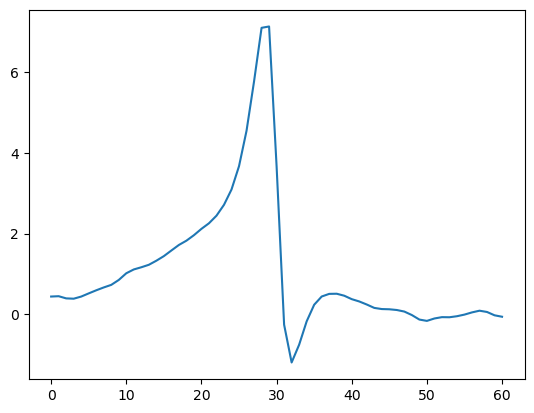

In [21]:
plt.plot(ANNslope_m*86400.)

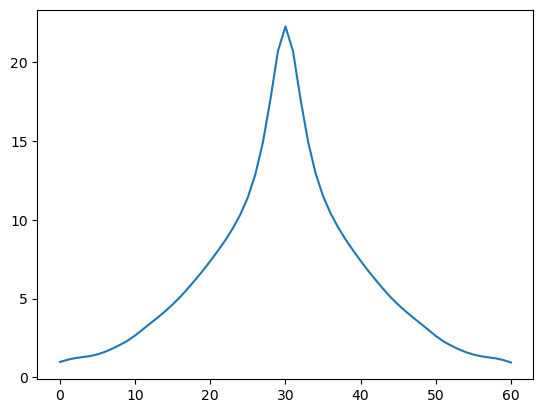

In [22]:
plt.plot(ANNslope_u)

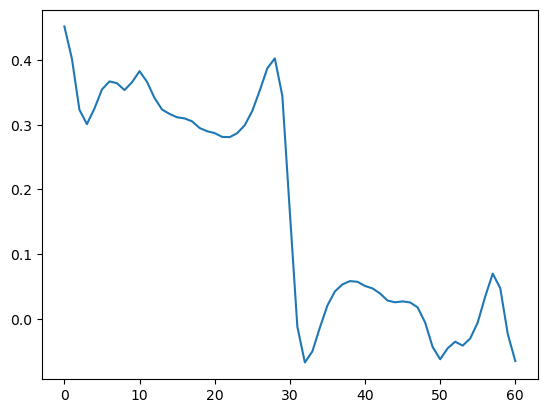

In [23]:
plt.plot(ANNb)

### For DJF

In [24]:
DJF_mlag = mlag_window.sel(time=mlag_window.time.dt.month.isin([12, 1, 2]))
DJF_ulag = ulag_window.sel(time=ulag_window.time.dt.month.isin([12, 1, 2]))

In [25]:
DJF_SAMindex = samindex.sel(time=samindex.time.dt.month.isin([12, 1, 2]))

In [26]:
from scipy.stats import linregress

DJFslope_m = np.zeros((61))
DJFslope_u = np.zeros((61))

for lag in range (0,61):
    DJFslope_m[lag], _, _, _, _ = linregress(DJF_SAMindex.to_numpy(), DJF_mlag[lag,:].to_numpy())  #slope, intercept, r_value, p_value, std_err = linregress(x, y)
    DJFslope_u[lag], _, _, _, _ = linregress(DJF_SAMindex.to_numpy(), DJF_ulag[lag,:].to_numpy())

In [27]:
DJFb = DJFslope_m*86400/DJFslope_u
DJFb_avg= np.mean(DJFb[31+7:31+15])

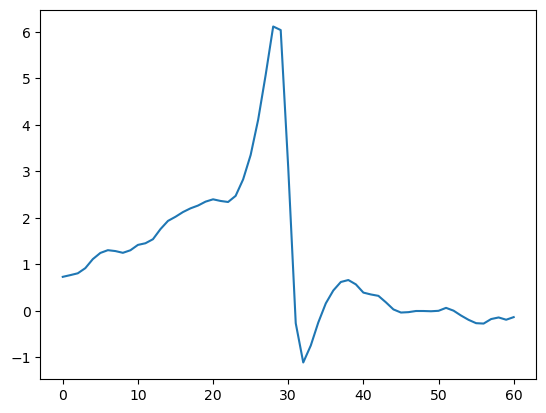

In [28]:
import matplotlib.pyplot as plt
plt.plot(DJFslope_m*86400)

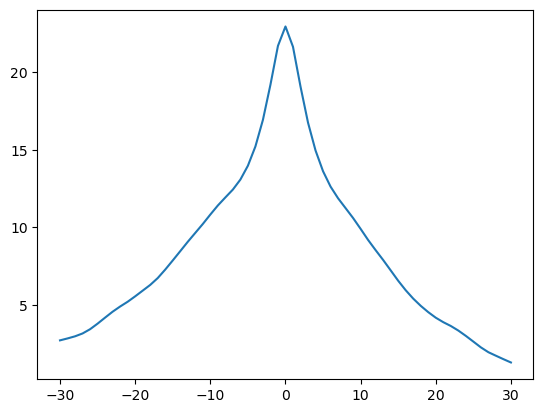

In [29]:
plt.plot(lags_size,DJFslope_u)

### For NDJ

In [30]:
NDJ_mlag = mlag_window.sel(time=mlag_window.time.dt.month.isin([11, 12, 1]))
NDJ_ulag = ulag_window.sel(time=ulag_window.time.dt.month.isin([11, 12, 1]))

In [31]:
NDJ_SAMindex = samindex.sel(time=samindex.time.dt.month.isin([11, 12, 1]))

In [32]:
NDJslope_m = np.zeros((61))
NDJslope_u = np.zeros((61))

for lag in range (0,61):
    NDJslope_m[lag], _, _, _, _ = linregress(NDJ_SAMindex.to_numpy(), NDJ_mlag[lag,:].to_numpy())  #slope, intercept, r_value, p_value, std_err = linregress(x, y)
    NDJslope_u[lag], _, _, _, _ = linregress(NDJ_SAMindex.to_numpy(), NDJ_ulag[lag,:].to_numpy())

In [33]:
NDJb = NDJslope_m*86400/NDJslope_u
NDJb_avg= np.mean(NDJb[31+7:31+15])

### For FMA

In [34]:
FMA_mlag = mlag_window.sel(time=mlag_window.time.dt.month.isin([2, 3, 4]))
FMA_ulag = ulag_window.sel(time=ulag_window.time.dt.month.isin([2, 3, 4]))

In [35]:
FMA_SAMindex = samindex.sel(time=samindex.time.dt.month.isin([2, 3, 4]))

In [36]:
FMAslope_m = np.zeros((61))
FMAslope_u = np.zeros((61))

for lag in range (0,61):
    FMAslope_m[lag], _, _, _, _ = linregress(FMA_SAMindex.to_numpy(), FMA_mlag[lag,:].to_numpy())  #slope, intercept, r_value, p_value, std_err = linregress(x, y)
    FMAslope_u[lag], _, _, _, _ = linregress(FMA_SAMindex.to_numpy(), FMA_ulag[lag,:].to_numpy())

In [37]:
np.savetxt('ERA5_1980_2023_ANNslope_m.out', ANNslope_m*86400, delimiter=',')
np.savetxt('ERA5_1980_2023_NDJslope_m.out', NDJslope_m*86400, delimiter=',')
np.savetxt('ERA5_1980_2023_FMAslope_m.out', FMAslope_m*86400, delimiter=',')

In [38]:
np.savetxt('ERA5_1980_2023_ANNslope_u.out', ANNslope_u, delimiter=',')
np.savetxt('ERA5_1980_2023_NDJslope_u.out', NDJslope_u, delimiter=',')
np.savetxt('ERA5_1980_2023_FMAslope_u.out', FMAslope_u, delimiter=',')

### For OND

In [32]:
OND_mlag = mlag_window.sel(time=mlag_window.time.dt.month.isin([10, 11, 12]))
OND_ulag = ulag_window.sel(time=ulag_window.time.dt.month.isin([10, 11, 12]))
OND_SAMindex = samindex.sel(time=samindex.time.dt.month.isin([10, 11, 12]))

In [33]:
ONDslope_m = np.zeros((61))
ONDslope_u = np.zeros((61))

for lag in range (0,61):
    ONDslope_m[lag], _, _, _, _ = linregress(OND_SAMindex.to_numpy(), OND_mlag[lag,:].to_numpy())  #slope, intercept, r_value, p_value, std_err = linregress(x, y)
    ONDslope_u[lag], _, _, _, _ = linregress(OND_SAMindex.to_numpy(), OND_ulag[lag,:].to_numpy())

In [34]:
ONDb = ONDslope_m*86400/ONDslope_u
ONDb_avg= np.mean(ONDb[31+7:31+15])

### For JFM

In [35]:
JFM_mlag = mlag_window.sel(time=mlag_window.time.dt.month.isin([1, 2, 3]))
JFM_ulag = ulag_window.sel(time=ulag_window.time.dt.month.isin([1, 2, 3]))
JFM_SAMindex = samindex.sel(time=samindex.time.dt.month.isin([1, 2, 3]))

In [36]:
JFMslope_m = np.zeros((61))
JFMslope_u = np.zeros((61))

for lag in range (0,61):
    JFMslope_m[lag], _, _, _, _ = linregress(JFM_SAMindex.to_numpy(), JFM_mlag[lag,:].to_numpy())  #slope, intercept, r_value, p_value, std_err = linregress(x, y)
    JFMslope_u[lag], _, _, _, _ = linregress(JFM_SAMindex.to_numpy(), JFM_ulag[lag,:].to_numpy())

In [37]:
JFMb = JFMslope_m*86400/JFMslope_u
JFMb_avg= np.mean(JFMb[31+7:31+15])

In [38]:
#print(ANNb_avg)
print(DJFb_avg)
print(NDJb_avg)
print(ONDb_avg)
print(JFMb_avg)

0.03155463123674737
0.0570580796279831
0.07917219226487243
-0.015225358377680272


In [39]:
from scipy.stats import linregress

mon3b = np.zeros((12))

for mon in range (0,12):
    if mon == 0:
        ms = 12
    else:
        ms= mon
    if mon == 11:
        me = 1
    else:
        me= mon+2
        
    mon3_mlag = mlag_window.sel(time=mlag_window.time.dt.month.isin([ms, mon+1, me]))
    mon3_ulag = ulag_window.sel(time=ulag_window.time.dt.month.isin([ms, mon+1, me]))
    mon3_SAMindex = samindex.sel(time=samindex.time.dt.month.isin([ms, mon+1, me]))
    mon3slope_m = np.zeros((61))
    mon3slope_u = np.zeros((61))

    for lag in range (0,61):
        mon3slope_m[lag], _, _, _, _ = linregress(mon3_SAMindex.to_numpy(), mon3_mlag[lag,:].to_numpy())  #slope, intercept, r_value, p_value, std_err = linregress(x, y)
        mon3slope_u[lag], _, _, _, _ = linregress(mon3_SAMindex.to_numpy(), mon3_ulag[lag,:].to_numpy())
    
    b = mon3slope_m*86400/mon3slope_u
    mon3b[mon] = np.mean(b[31+7:31+15])
    
    print(mon3b)

[0.03155463 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[ 0.03155463 -0.01522536  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[ 0.03155463 -0.01522536 -0.09829233  0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[ 0.03155463 -0.01522536 -0.09829233 -0.07212399  0.          0.
  0.          0.          0.          0.          0.          0.        ]
[ 0.03155463 -0.01522536 -0.09829233 -0.07212399 -0.02767255  0.
  0.          0.          0.          0.          0.          0.        ]
[ 0.03155463 -0.01522536 -0.09829233 -0.07212399 -0.02767255  0.08068194
  0.          0.          0.          0.          0.          0.        ]
[ 0.03155463 -0.01522536 -0.09829233 -0.07212399 -0.02767255  0.08068194
  0.06257944  0.          0.          0.          0.          0.        ]
[ 0.03155463 -0.0152253

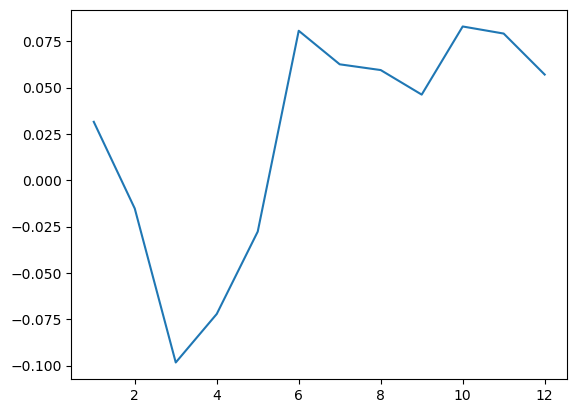

In [40]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,13,1),mon3b)

In [41]:
ERA5_timescale= np.loadtxt('../ERA51979_2023_Jul2Jun_timescale.out')

([<matplotlib.axis.XTick at 0x7ffd347792b0>,
 [Text(0, 0, 'Jul'),
  Text(1, 0, 'Aug'),
  Text(2, 0, 'Sep'),
  Text(3, 0, 'Oct'),
  Text(4, 0, 'Nov'),
  Text(5, 0, 'Dec'),
  Text(6, 0, 'Jan'),
  Text(7, 0, 'Feb'),
  Text(8, 0, 'Mar'),
  Text(9, 0, 'Apr'),
  Text(10, 0, 'May'),
  Text(11, 0, 'Jun')])

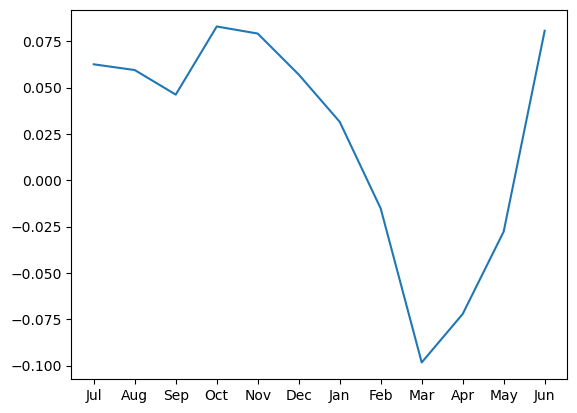

In [42]:
shifted_mon3b = np.roll(mon3b, 6) 
plt.plot(shifted_mon3b)
plt.xticks(np.arange(0,12,1),['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb', 'Mar','Apr','May','Jun'])

(14,)


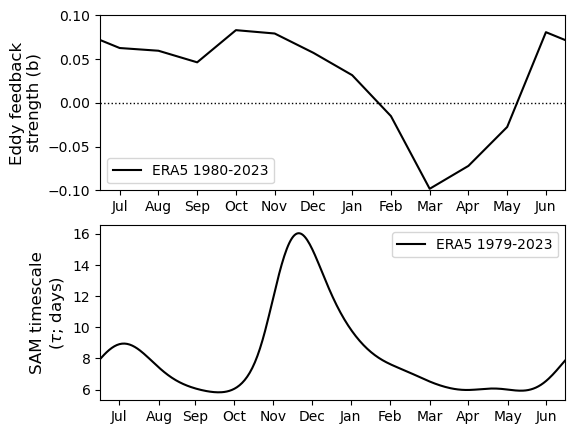

In [43]:
import matplotlib.pyplot as plt
days=np.arange(0, 365, 1)

xlabels_ex=['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb', 'Mar','Apr','May','Jun','Jul']
xlabels=['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb', 'Mar','Apr','May','Jun']
fig, axs = plt.subplots(2, 1, figsize=(6, 5))

#trans_mon3b= 0.5*(shifted_mon3b[0]+shifted_mon3b[-1])
#print(trans_mon3b)
exten_mon3b= np.append(shifted_mon3b ,shifted_mon3b[0])
exten_mon3b= np.append(shifted_mon3b[-1], exten_mon3b)
axs[0].plot(exten_mon3b,'k',label='ERA5 1980-2023')
axs[0].legend()
print(exten_mon3b.shape)
axs[0].axhline(0, color='black', lw=1,ls='dotted')
axs[0].set_xticks(np.arange(0,14,1), labels=xlabels_ex)
axs[0].set_ylabel('Eddy feedback\nstrength (b)',fontsize=12)
axs[0].set_xlim(0.5, 12.5)
axs[0].set_ylim(-0.1, 0.1)
#axs[0].plot(np.cumsum(exten_mon3b),'r')

axs[1].plot(days, ERA5_timescale,'k',label='ERA5 1979-2023')
#plt.xticks([15, 31+15, 59+15,90+15,120+15,151+15, 181+15,212+15,243+15,273+15,304+15,334+15], ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb', 'Mar','Apr','May','Jun'])
axs[1].set_xticks([15, 31+15, 59+15,90+15,120+15,151+15, 181+15,212+15,243+15,273+15,304+15,334+15], labels=xlabels)
axs[1].set_ylabel('SAM timescale\n('r'$\tau$''; days)',fontsize=12)
axs[1].set_xlim(0, 364)
axs[1].legend()
plt.savefig('Eddyfeedbackstrength_ERA5_SAMtimescale', bbox_inches='tight', dpi=200)
plt.show()

np.savetxt('ERA5_1980_2023_Eddyfeedbackstrength.out', exten_mon3b, delimiter=',')

In [44]:
# Assuming mlag_window is your DataArray

dayavg_b = np.zeros((37))

days = range(1,366,10)
#days = range(1,11,10)
# Create rolling selection in 10-day intervals
for count, start_day in enumerate(days):
#for start_day in range(1, 366, 10):  # Iterates through days of the year in 10-day steps
    
    end_day = min(start_day+89, 365)  # Ensure we don't exceed 365 days
    day_mlag = mlag_window.sel(time=(mlag_window.time.dt.dayofyear >= start_day) & 
                                  (mlag_window.time.dt.dayofyear <= end_day))
    day_ulag = ulag_window.sel(time=(ulag_window.time.dt.dayofyear >= start_day) & 
                                  (ulag_window.time.dt.dayofyear <= end_day))
    day_sam = samindex.sel(time=(samindex.time.dt.dayofyear >= start_day) & 
                                  (samindex.time.dt.dayofyear <= end_day))
    #print(count, start_day, end_day)
    #print(day_mlag.shape)
    dayslope_m = np.zeros((61))
    dayslope_u = np.zeros((61))

    for lag in range (0,61):
        dayslope_m[lag], _, _, _, _ = linregress(day_sam.to_numpy(), day_mlag[lag,:].to_numpy())  #slope, intercept, r_value, p_value, std_err = linregress(x, y)
        dayslope_u[lag], _, _, _, _ = linregress(day_sam.to_numpy(), day_ulag[lag,:].to_numpy())
    
    dayb = dayslope_m*86400/dayslope_u
    dayavg_b[count] = np.mean(dayb[31+7:31+15])
    
    #print(mon3b)

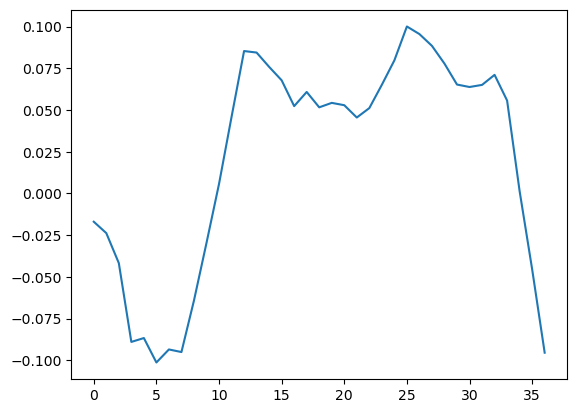

In [46]:
import matplotlib.pyplot as plt
plt.plot(dayavg_b)

In [59]:
yearlist= list(range(total_years))
from random import choices
# Bootstrap sampling 
bootsize=1000
#bootsize=10

ACF_ens_bootstrap = xr.DataArray(np.full((51,365,bootsize),fill_value=np.nan), dims=["lags","time","samples"], coords= coords)

for i in range(bootsize):
    print('i=',i)
    sample_years = choices(yearlist, k=total_years) 

    for days in range(0,365):
        for lags in range(51): 
        
            numerator = 0.
            denominatorA = 0.
            denominatorB = 0.
           
            for yy in sample_years:
                
                if math.isnan(SAM_window_noleap_np[0,days+365*yy]) != True :
                    numerator    =  numerator   + (SAM_window_noleap_np[0,days+365*yy]-mean_SAM_np[0,days])*(SAM_window_noleap_np[0+lags,days+365*yy]-mean_SAM_np[0+lags,days])
                    denominatorA =  denominatorA + (SAM_window_noleap_np[0,days+365*yy]-mean_SAM_np[0,days])**2
                    denominatorB =  denominatorB + (SAM_window_noleap_np[0+lags,days+365*yy]-mean_SAM_np[0+lags,days])**2  
            #if math.isnan(SAM_window_noleap_np[0,days+365*yy]) != True :
            #    numerator    =  numerator   + (SAM_window_noleap_np[0,days+365*yy])*(SAM_window_noleap_np[0+lags,days+365*yy])
            #    denominatorA =  denominatorA + (SAM_window_noleap_np[0,days+365*yy])**2
            #    denominatorB =  denominatorB + (SAM_window_noleap_np[0+lags,days+365*yy])**2      
            #else:
            #    print('NAN found at days:',days,'year=',yy)
         
            ACF_ens_bootstrap[lags, days, i] = numerator/((denominatorA*denominatorB)**0.5) 


i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10
i= 11
i= 12
i= 13
i= 14
i= 15
i= 16
i= 17
i= 18
i= 19
i= 20
i= 21
i= 22
i= 23
i= 24
i= 25
i= 26
i= 27
i= 28
i= 29
i= 30
i= 31
i= 32
i= 33
i= 34
i= 35
i= 36
i= 37
i= 38
i= 39
i= 40
i= 41
i= 42
i= 43
i= 44
i= 45
i= 46
i= 47
i= 48
i= 49
i= 50
i= 51
i= 52
i= 53
i= 54
i= 55
i= 56
i= 57
i= 58
i= 59
i= 60
i= 61
i= 62
i= 63
i= 64
i= 65
i= 66
i= 67
i= 68
i= 69
i= 70
i= 71
i= 72
i= 73
i= 74
i= 75
i= 76
i= 77
i= 78
i= 79
i= 80
i= 81
i= 82
i= 83
i= 84
i= 85
i= 86
i= 87
i= 88
i= 89
i= 90
i= 91
i= 92
i= 93
i= 94
i= 95
i= 96
i= 97
i= 98
i= 99
i= 100
i= 101
i= 102
i= 103
i= 104
i= 105
i= 106
i= 107
i= 108
i= 109
i= 110
i= 111
i= 112
i= 113
i= 114
i= 115
i= 116
i= 117
i= 118
i= 119
i= 120
i= 121
i= 122
i= 123
i= 124
i= 125
i= 126
i= 127
i= 128
i= 129
i= 130
i= 131
i= 132
i= 133
i= 134
i= 135
i= 136
i= 137
i= 138
i= 139
i= 140
i= 141
i= 142
i= 143
i= 144
i= 145
i= 146
i= 147
i= 148
i= 149
i= 150
i= 151
i= 152
i= 153
i= 154
i= 155
i= 156
i= 157
i= 1